In [22]:
import pandas as pd
import requests, json, logging
from bs4 import BeautifulSoup
from io import BytesIO
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter,DayLocator,MonthLocator

In [2]:

# =============================================================================
# set logging
logger=logging.getLogger('murray_irrigation')
logger.setLevel(logging.INFO)
handler=logging.StreamHandler()
# handler.setLevel(logging.INFO)
formatter = logging.Formatter('[%(asctime)s - %(name)s - %(levelname)s]: %(message)s',datefmt=r'%Y-%m-%d %H:%M:%S')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.info('Program starts...downloading Murray Irrigation data...')
requests.urllib3.disable_warnings()



# =============================================================================
headers={'accept':'*/*', 
        'accept-language':'en-US,en;q=0.9,zh-CN;q=0.8,zh;q=0.7', 
        'sec-ch-ua-platform': "Windows", 
        'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36'
}



# =============================================================================
# define url generator function
def generate_url(mode):
    return f"https://api01.murrayirrigation.com.au/v1.0/market/{mode}"



# =============================================================================
# define worker function
def get_byte_data(url,headers):
    # make requests
    response=requests.get(url,headers,verify=False)
    response.raise_for_status()
    logger.info(f"{url.split('/')[-1]} data downloaded successfully")
    # initialize byteIO
    f=BytesIO()
    # write to byteIO
    for chunk in response.iter_content(chunk_size=1024):
        f.write(chunk)
    # reset seeker
    f.seek(0)
    return f



# =============================================================================
def get_dailySales(data):
    df=pd.read_json(data)
    df['Date']=df['Date'].dt.strftime(r'%d-%b-%Y')
    return df


# =============================================================================
def json2df(json):
    df=pd.DataFrame.from_dict(json)
    return df



# =============================================================================
def get_waterData(data):
    soup=BeautifulSoup(data,'lxml').text
    soup_json=json.loads(soup)
    outputs={}
    for key,val in soup_json.items():
        outputs.setdefault(key,json2df(val))
    return outputs



# =============================================================================
# def dump df function
def dump_dailySales_df(df,fname='dailySales.csv'):
    fname=Path(__file__).resolve().parent / fname
    logger.info(f"Now dumping {len(df)} rows to {fname.name}...")
    df.to_csv(fname,header=True,index=False)
    logger.info(f"Successfully dumped {len(df)} rows to {fname.name}")



# =============================================================================
def dump_waterData_df(outputs,fname):
    fname= Path(__file__).resolve().parent / fname
    with pd.ExcelWriter(fname,mode='w') as wf:
        for key, df in outputs.items():
            logger.info(f"Now dumping {len(df)} rows of {key} to {fname.name}...")
            df.to_excel(wf,index=False, header=True,sheet_name=key)
            logger.info(f"Successfully dumped {len(df)} rows to {fname.name}")




# =============================================================================
def main(target):
    url=generate_url(target)
    data=get_byte_data(url,headers)
    if target=='dailysales':
        df=get_dailySales(data)
        dump_dailySales_df(df)
    # elif target=='waterdata':
    else:
        outputs=get_waterData(data)
        dump_waterData_df(outputs,fname=f"{target}_dumps.xlsx")


# =============================================================================
def get_data(target):
    url=generate_url(target)
    data=get_byte_data(url,headers)
    if target=='dailysales':
        df=get_dailySales(data)
        return df
    # elif target=='waterdata':
    else:
        outputs=get_waterData(data)
        return outputs



[2023-04-24 11:28:30 - murray_irrigation - INFO]: Program starts...downloading Murray Irrigation data...


[2023-04-24 11:46:56 - murray_irrigation - INFO]: dailysales data downloaded successfully


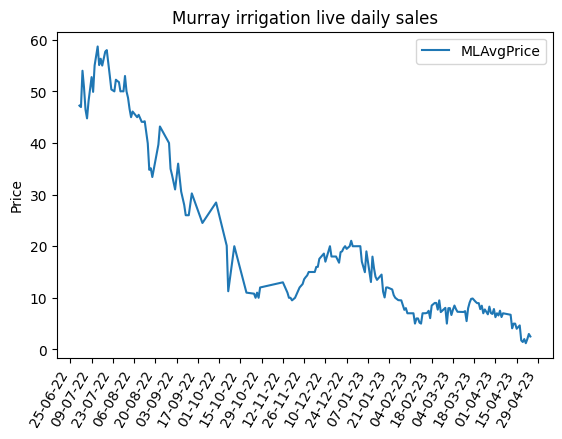

In [33]:
all_downloadable_data=('exchangetables','dailysales','waterdata')
target=all_downloadable_data[1]
# main(target)
df=get_data(target)
df_wt=df[df['ListingType']=='WT']
fig,ax=plt.subplots()
ax.plot(pd.to_datetime(df_wt['Date']),df_wt['MLAvgPrice'],label='MLAvgPrice')
# ax.plot(pd.to_datetime(df_wt['Date']),df_wt['MLSold'],label='ML sold')
date_fmt=DateFormatter('%d-%m-%y')
ax.xaxis.set_major_formatter(date_fmt)
# ax.xaxis.set_major_locator(MonthLocator(interval=1))
ax.xaxis.set_major_locator(DayLocator(interval=14))
ax.set_title('MURRAY IRRIGATION LIVE DAILY SALES'.capitalize())
ax.legend()
ax.set_ylabel('Price')
# set font and rotation for date tick labels
plt.gcf().autofmt_xdate(rotation=60)

In [41]:
df.empty

False